# *K-Means* Clustering For 1000 Manga List from myanimelist.net

#### Authors: @jakajek
#### https://github.com/jakajek

## Import library
In this section we will import library tools like `pandas`, `matplotlib`, and `sklearn`. From `sklearn` we will use `cluster` for `KMeans`, `preprocessing` for `StandardScaler` and `metrics` for `silhouette_score`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

## Data Exploration
Next we use data from https://www.kaggle.com/astronautelvis/top-1000-ranked-mangas-by-myanimelist

**Why I choose this data for *K-Means* Clustering?** as a manga readers when i visit https://myanimelist.net/topmanga.php it's hard for me to choose what is the next manga to read.

**But you can start from 1st rank and you can choose by score isn't?** to be honest it's not simple like that my brother, if we look closely the score and the ranks it seems sus because the numbers of members. Mangas like *JoJo no Kimyou na Bouken Part 7: Steel Ball Run* is 2nd at the rank and have 9.23 score but it only have 160,780 members, then it's drives us to early conclusions that rank in https://myanimelist.net/topmanga.php can manipulated by *hardcore* fans.

**Why choose *K-Means* clustering methods?** *K-Means* is one simple clustering methods to separate data by specific features. In this data, we can choose `Scored_by`, `Favorites` and `Score` as features to use (continuous var is a must btw).

Next we load the data to see whats looks like this data

In [2]:
data_manga = pd.read_csv("https://raw.githubusercontent.com/jakajek/current-projekt/main/data/top_1000_manga.csv", index_col = 0)
data_manga.head()

,Title,Title_Synonym,Title_Japanese,Status,Volumns,Chapters,Publishing,Rank,Score,Scored_by,Popularity,Memebers,Favorites,Synopsis,Publish_period,Genre
0,Berserk,Berserk,ベルセルク,Publishing,unkown,unkown,True,1,9.39,201756,2,427894,80308,"Guts, a former mercenary now known as the ""Bla...","Aug 25, 1989 to present","'Action', 'Adventure', 'Demons', 'Drama', 'Fan..."
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,unkown,ジョジョの奇妙な冒険 Part7 STEEL BALL RUN,Finished,24,96,False,2,9.23,94427,29,160782,27459,"In the American Old West, the world's greatest...","Jan 19, 2004 to Apr 19, 2011","'Action', 'Adventure', 'Mystery', 'Historical'..."
2,One Piece,One Piece,ONE PIECE,Publishing,unkown,unkown,True,3,9.15,249936,3,410522,82310,"Gol D. Roger, a man referred to as the ""Pirate...","Jul 22, 1997 to present","'Action', 'Adventure', 'Comedy', 'Fantasy', 'S..."
3,Vagabond,Vagabond,バガボンド,On Hiatus,37,327,False,4,9.13,72613,19,211345,21596,"In 16th century Japan, Shinmen Takezou is a wi...","Sep 3, 1998 to May 21, 2015","'Action', 'Adventure', 'Drama', 'Historical', ..."
4,Monster,Monster,MONSTER,Finished,18,162,False,5,9.10,57801,33,148764,13049,"Kenzou Tenma, a renowned Japanese neurosurgeon...","Dec 5, 1994 to Dec 20, 2001","'Mystery', 'Drama', 'Psychological', 'Seinen'"


### Data Cleaning

As we see the data contains information what manga is Publishing, Finished, or On Hiatus in `Status`. Because my concern is only on manga with status **Publishing** and **Finished**, we must filter the `Status` first. Next task is we only use selected features and drop others to create new data frame for the analysis

In [3]:
use_col = data_manga['Status'].isin(['Publishing','Finished'])
del_col = ['Title_Synonym', 'Title_Japanese', 'Status','Chapters', 'Volumns', 'Publishing', 'Memebers', 'Synopsis', 'Publish_period', 'Genre','Popularity']
df_manga = data_manga[use_col].drop(columns = del_col)
df_manga.head()

,Title,Rank,Score,Scored_by,Favorites
0,Berserk,1,9.39,201756,80308
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,2,9.23,94427,27459
2,One Piece,3,9.15,249936,82310
4,Monster,5,9.10,57801,13049
5,Fullmetal Alchemist,6,9.08,130375,26753


Because we filter `Status` only on **Publishing** and **Finished** mangas it will impact to the length of the data

In [4]:
before = len(data_manga)
after = len(df_manga)
difference = before - after
print("The difference length of the data is: ", difference)

The difference length of the data is:  10


Before we jump to next step, we must check the duplicate data first. We choos `Tittle` as features to check the dupulicate data

In [5]:
df_manga['is_duplicated'] = df_manga.duplicated(subset=['Title'])
df_manga['is_duplicated'].sum()

45

Because it's have duplicate title next task is drop the duplicate data and only keep ones. After that we check the length of our data frame

In [6]:
df_manga = df_manga.drop_duplicates(subset=['Title'])
len(df_manga)

946

After that we can finish the cleaning phase and see the data frame looks now

In [7]:
df_manga = df_manga.drop(columns = ['is_duplicated'])
df_manga.head()

,Title,Rank,Score,Scored_by,Favorites
0,Berserk,1,9.39,201756,80308
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,2,9.23,94427,27459
2,One Piece,3,9.15,249936,82310
4,Monster,5,9.10,57801,13049
5,Fullmetal Alchemist,6,9.08,130375,26753


## *K-Means* Clustering

First step in clustering is we must decide the numbers of cluster based on the data we have. In this case we will use *elbow method* to determine the number of cluster in a data set. The *elbow method* is a heuristic that consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use (https://en.wikipedia.org/wiki/Elbow_method_(clustering))

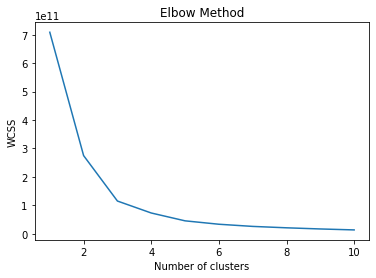

In [8]:
X = (df_manga[['Scored_by', 'Favorites', 'Score']])
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Because we use "elbow" or "knee of a curve", the plot showing us tha optimal number of cluster in our data set is 3 (between 2 and 4). So we will set the number of cluster in next step to 3

In [9]:
kmeans = KMeans(n_clusters=3, random_state=0)
var = df_manga[['Scored_by', 'Favorites']]
df_manga['cluster'] = kmeans.fit_predict(var)

centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

df_manga['cen_x'] = df_manga.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
df_manga['cen_y'] = df_manga.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
print(df_manga[['Title','cluster','cen_x','cen_y']])

                                                Title  cluster          cen_x  \
0                                             Berserk        1  187632.833333   
1     JoJo no Kimyou na Bouken Part 7: Steel Ball Run        2   53998.693878   
2                                           One Piece        1  187632.833333   
4                                             Monster        2   53998.693878   
5                                 Fullmetal Alchemist        1  187632.833333   
...                                               ...      ...            ...   
996                              Itsuwaribito◆Utsuho◆        0    6086.722488   
997                                    Kakegurui Twin        0    6086.722488   
998               Boku to Kimi no Taisetsu na Hanashi        0    6086.722488   
999                                             Dokgo        0    6086.722488   
1000                     Maiko-san Chi no Makanai-san        0    6086.722488   

             cen_y  
0     

### Visualize

Now we have new columns in data set contains the information of cluster and centroids, next we visualize the result using plot. For better plot, we must differentiate the colour of each cluster

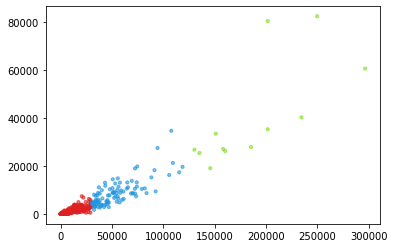

In [10]:
colors = ['#DF2020', '#81DF20', '#2095DF']
df_manga['c'] = df_manga.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
plt.scatter(df_manga.Scored_by, df_manga.Favorites, c=df_manga.c, alpha = 0.6, s=10)

The plot showing 3 different colours for each cluster (red, blue and green). As we can see the "green" clusters contain information which manga should we read before sleep :)

Before we find which manga is in "green" cluster, we must check the accuracy of our result

In [11]:
z = StandardScaler()
trans = z.fit_transform(var)
pred = kmeans.predict(var)
silhouette_score(trans, pred)

0.7992844306666054

Based on the value of accuracy, we are confident to go to the next step

To get more information we will make a 3d visualization

In [12]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(df_manga.Scored_by, df_manga.Favorites, df_manga.Score, c=df_manga.c, s=15)
ax.set_xlabel('Scored_by')
ax.set_ylabel('Favorites')
ax.set_zlabel('Score')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In the 3d graphs we can each cluster differentiate more clear and see that not all "green" cluster have a high `Score`

Next we create new data frame that contains new `cluster` features

In [13]:
to_frame = df_manga['cluster'].to_frame()
df_clust = pd.concat([df_manga.Title,df_manga.Rank,df_manga.Score,df_manga.Scored_by,df_manga.Favorites,to_frame], axis=1)
print(df_clust)

                                                Title  Rank  Score  Scored_by  \
0                                             Berserk     1   9.39     201756   
1     JoJo no Kimyou na Bouken Part 7: Steel Ball Run     2   9.23      94427   
2                                           One Piece     3   9.15     249936   
4                                             Monster     5   9.10      57801   
5                                 Fullmetal Alchemist     6   9.08     130375   
...                                               ...   ...    ...        ...   
996                              Itsuwaribito◆Utsuho◆   994   7.86       1623   
997                                    Kakegurui Twin   970   7.86       1339   
998               Boku to Kimi no Taisetsu na Hanashi  1000   7.85       4014   
999                                             Dokgo  1022   7.85       2037   
1000                     Maiko-san Chi no Makanai-san  1023   7.85        799   

      Favorites  cluster  


## Conclusion

This analysis shows us that *K-Means* clustering is a simple way to get a lot of information from a data set. But we must careful when choose the features to clustering, we must have an insight of the data set first before we go through. The *elbow method* is a simple way too for us to determine numbers of cluster in *K-Means* clustering, maybe in next proect we will use different method to determine numbers of cluster even different clustering method in python universe.

So there are the conclusion of this analysis, first we get the optimal numbers of cluster from data set is 3 based on *elbow method*, and here there are the length of the data for ech clusters

In [14]:
group_clust = df_clust.groupby("cluster")["Title"].count()
print(group_clust)

cluster
0    836
1     12
2     98
Name: Title, dtype: int64


Because we want to know top priority manga to read we choose "green" cluster which is cluster 1, so we create new data frame that only show us the data from cluster 1

In [15]:
df_manga_new = df_clust[df_clust['cluster'] == 1]
df_manga_new.insert(0, 'No.', range(1, 1 + len(df_manga_new)))
print(df_manga_new)

     No.                  Title  Rank  Score  Scored_by  Favorites  cluster
0      1                Berserk     1   9.39     201756      80308        1
2      2              One Piece     3   9.15     249936      82310        1
5      3    Fullmetal Alchemist     6   9.08     130375      26753        1
23     4          Solo Leveling    24   8.85     135251      25391        1
39     5          One Punch-Man    41   8.73     158388      27068        1
43     6             Death Note    44   8.72     185500      27864        1
49     7           Chainsaw Man    50   8.68     151198      33419        1
79     8     Shingeki no Kyojin    81   8.59     296689      60533        1
112    9            Tokyo Ghoul   111   8.52     201733      35247        1
290   10       Kimetsu no Yaiba   295   8.28     145839      19028        1
294   11  Boku no Hero Academia   299   8.28     160282      26204        1
583   12                 Naruto   583   8.06     234647      40200        1


From that's data frame we can see 12 publishing and finished mangas in cluster 1 that top priority to read for. Enjoy!